In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d  
import cv2 as cv

import os
import sys
from copy import deepcopy

# Add src to path
sys.path.append("src")
from BWImage import BWImage
from sff import ML
from sff import SML
from sff import SFF


## Jupyter notebooks settings.

# Reload modules before executing each cell.
%load_ext autoreload
%autoreload 2 

# Print all print statements.
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

# Set white as color for pixels with no value.
BWImage.blank_value = 0

# Introduction

In this lab 

## Theory


## Implementation.
**Input**: `data/input`

**Output**: `data/output`

**Source code**: `src`

* `BWImage.py`: Same from my previous labs. Implements a class with methods for basic image I/O.

* `utils.py`: Contains functions important to this lab. 
    - The `get_gaussian_kernel` function takes as input a $\sigma$ value and gives the $v$ described above. Same as lab-4.
    - The `convolve` function takes as input a image in BWImage format and $v$ and returns convolved image. Same as lab-4.
    - Unlike the `convolve` function above, the `convolve_pixel` function takes as input the pixel location in addition to the image and filter and return the intensity value of the pixel after convolution with the filter.

* `get_sigma`: Function to calculate sigma. There are 

# Result

## Import data and visualize.

In [2]:
# Read input.
import scipy.io as sio
stack_mat = sio.loadmat('data/input/stack.mat')

# Print meta info.  
print("Header: ", stack_mat['__header__'])
print("Version: ", stack_mat['__version__'])
print("Number of frames", stack_mat['numframes'])
print("Dimension of each frame: ", stack_mat['frame001'].shape)

# Preprocess data.
img_stack = []
for i in range(stack_mat['numframes'][0][0]):
    if i < 9:
        img_stack.append(stack_mat['frame00' + str(i+1)])
    elif i < 99:
        img_stack.append(stack_mat['frame0' + str(i+1)])
    else:
        img_stack.append(stack_mat['frame' + str(i+1)])
img_stack = np.array(img_stack)

Header:  b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri Feb 05 14:40:11 2010'
Version:  1.0
Number of frames [[100]]
Dimension of each frame:  (115, 115)


## Get shape.

In [3]:
# Get the depth at each pixel.
qs = [0, 1, 2]
depths = []
for q in qs:
    d = SFF(img_stack, q)
    depths.append(d)

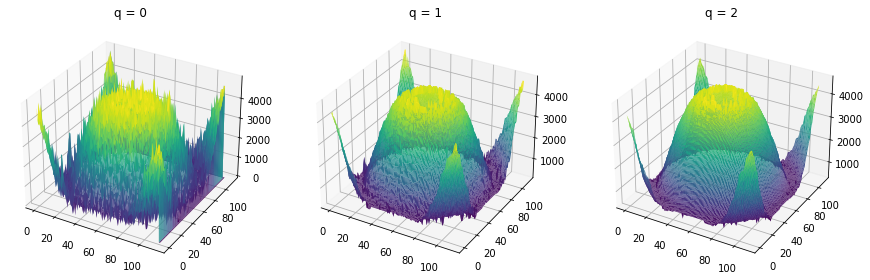

In [4]:
## Plot the 3-D shape.
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={"projection": "3d"})

for q in qs:
    x = np.linspace(0, depths[q].shape[0]-1, depths[q].shape[0])
    y = np.linspace(0, depths[q].shape[1]-1, depths[q].shape[1])
    x, y = np.meshgrid(x, y)
    axs[q].plot_surface(x, y, depths[q], rstride=1, cstride=1, cmap='viridis', edgecolor='none')
    axs[q].set_title("q = " + str(q))